In [1]:
#importing packages
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import nltk
import datetime
from os import path
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from datetime import datetime
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score, mean_squared_error, confusion_matrix, classification_report, f1_score, roc_auc_score
from dateutil.relativedelta import relativedelta
from scipy.stats import f_oneway, ttest_ind, chi2_contingency
from pycaret.classification import *
from lightgbm import LGBMClassifier

Importing DataBase

In [2]:
statd = pd.read_csv("statd.csv")

In [3]:
statd = statd.fillna('N/A')

In [4]:
statd = statd.query("drinks != 'N/A'")

In [5]:
statd.head()

,age,status,sex,orientation,body_type,diet,drinks,drugs,height,income,...,pacific islander,native american,middle eastern,indian,location,sign,religion,education,offspring,lang_spoken
0,22,single,m,straight,a little extra,anything,socially,never,190.0,104319.248826,...,0,0,0,0,california,gemini,agnosticism,Not Graduated,No Kids,1
1,35,single,m,straight,average,other,often,sometimes,178.0,80000.000000,...,0,0,0,0,california,cancer,agnosticism,Not Graduated,No Kids,3
2,38,available,m,straight,thin,anything,socially,N/A,173.0,104319.248826,...,0,0,0,0,california,pisces,N/A,Post Graduate,N/A,3
3,23,single,m,straight,thin,vegetarian,socially,N/A,180.0,20000.000000,...,0,0,0,0,california,pisces,N/A,Not Graduated,No Kids,2
4,29,single,m,straight,athletic,N/A,socially,never,168.0,104319.248826,...,0,0,0,0,california,aquarius,N/A,Graduated,N/A,1


In [6]:
statd.dtypes

age                   int64
status               object
sex                  object
orientation          object
body_type            object
diet                 object
drinks               object
drugs                object
height              float64
income              float64
job                  object
smokes               object
asian                 int64
white                 int64
black                 int64
other                 int64
hispanic / latin      int64
pacific islander      int64
native american       int64
middle eastern        int64
indian                int64
location             object
sign                 object
religion             object
education            object
offspring            object
lang_spoken           int64
dtype: object

PyCaret Analysis for the best possible label choice

In [7]:
s = setup(statd, target = 'drinks', categorical_features = ['status', 'sex', 'orientation', 'body_type', 'diet', 'smokes', 'drugs', 'job', 'asian', 'white', 'black', 'other', 'hispanic / latin', 'pacific islander', 'native american', 'middle eastern', 'indian', 'location', 'sign', 'religion', 'education', 'offspring'], numeric_features = ['height', 'income', 'age', 'lang_spoken'], ordinal_features = None, remove_outliers = True, session_id = 1312)

,Description,Value
0,Session id,1312
1,Target,drinks
2,Target type,Multiclass
3,Target mapping,"desperately: 0, not at all: 1, often: 2, rarely: 3, socially: 4, very often: 5"
4,Original data shape,"(56955, 27)"
5,Transformed data shape,"(54961, 105)"
6,Transformed train set shape,"(37874, 105)"
7,Transformed test set shape,"(17087, 105)"
8,Ordinal features,10
9,Numeric features,4


In [8]:
best_sm = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7335,0.5013,0.7335,0.5380,0.6207,0.0000,0.0000,8.3200
dummy,Dummy Classifier,0.7335,0.5000,0.7335,0.5380,0.6207,0.0000,0.0000,4.7190
ridge,Ridge Classifier,0.7331,0.0000,0.7331,0.5993,0.6229,0.0083,0.0373,4.7440
rf,Random Forest Classifier,0.7322,0.6478,0.7322,0.6215,0.6240,0.0105,0.0382,7.4350
lightgbm,Light Gradient Boosting Machine,0.7311,0.6645,0.7311,0.6125,0.6278,0.0264,0.0652,6.5040
ada,Ada Boost Classifier,0.7310,0.6116,0.7310,0.6181,0.6289,0.0297,0.0694,5.9510
gbc,Gradient Boosting Classifier,0.7300,0.6715,0.7300,0.6074,0.6262,0.0230,0.0565,23.6150
et,Extra Trees Classifier,0.7272,0.6324,0.7272,0.6066,0.6289,0.0291,0.0587,9.6040
nb,Naive Bayes,0.7239,0.5876,0.7239,0.5683,0.6205,0.0112,0.0245,4.8960
lda,Linear Discriminant Analysis,0.7112,0.6612,0.7112,0.6165,0.6302,0.0693,0.0934,5.2580


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [9]:
evaluate_model(best_sm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Creating the 2 dataframes we are going to use throughout the analysis: the inputs and the label

In [7]:
statd.isna().sum()

age                 0
status              0
sex                 0
orientation         0
body_type           0
diet                0
drinks              0
drugs               0
height              0
income              0
job                 0
smokes              0
asian               0
white               0
black               0
other               0
hispanic / latin    0
pacific islander    0
native american     0
middle eastern      0
indian              0
location            0
sign                0
religion            0
education           0
offspring           0
lang_spoken         0
dtype: int64

In [8]:
label = statd["drinks"]
statd2 = statd.drop("drinks", axis = 1)

In [9]:
statd2.columns

Index(['age', 'status', 'sex', 'orientation', 'body_type', 'diet', 'drugs',
       'height', 'income', 'job', 'smokes', 'asian', 'white', 'black', 'other',
       'hispanic / latin', 'pacific islander', 'native american',
       'middle eastern', 'indian', 'location', 'sign', 'religion', 'education',
       'offspring', 'lang_spoken'],
      dtype='object')

In [10]:
statd2.columns = [col.replace(" ", "_") for col in statd2.columns]

In [11]:
#there are columns already converted to dummies, and also there are numeric type columns
#I check the rest and call pandas' get_dummies function to convert all categoric data to numeric for statistical analysis
object_columns = statd2.select_dtypes(include=['object']).columns

In [12]:
statd_objects = statd2[object_columns]
df_encoded = pd.get_dummies(statd_objects, prefix=statd_objects.columns)
df_noredundance = pd.get_dummies(statd_objects, prefix=statd_objects.columns, drop_first = True)

In [13]:
df_encoded.columns

Index(['status_available', 'status_married', 'status_seeing someone',
       'status_single', 'status_unknown', 'sex_f', 'sex_m',
       'orientation_bisexual', 'orientation_gay', 'orientation_straight',
       ...
       'religion_islam', 'religion_judaism', 'religion_other',
       'education_Graduated', 'education_N/A', 'education_Not Graduated',
       'education_Post Graduate', 'offspring_Has Kids', 'offspring_N/A',
       'offspring_No Kids'],
      dtype='object', length=129)

In [14]:
df_encoded = df_encoded.loc[:, ~df_encoded.columns.str.contains("N/A")]

In [15]:
df_noredundance = df_noredundance.loc[:, ~df_noredundance.columns.str.contains("N/A")]

In [16]:
df_encoded.shape

(56955, 121)

In [17]:
#completing our input dataset ready for analysis
numeric_df = statd[statd.select_dtypes(exclude=['object']).columns]
stat_df = pd.concat([df_encoded, numeric_df], axis = 1)

Gradient Boosting and Initial Tests for Classification Models

In [21]:
X_train, X_test, y_train, y_test = train_test_split(stat_df, label, test_size=0.3, random_state = 1312)

In [22]:
best_train_f1 = 0
best_train_auc = 0
best_n_estimators = 0
best_max_features = 0
best_max_depth = 0

for n in range(1,10):
    for m in range(2,5):
        model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_features=n, max_depth=m)
        model.fit(X_train, y_train)

        # Calculate F1 score for training set
        f1_train = f1_score(y_train, model.predict(X_train), average='weighted')

        # Calculate ROC-AUC score for training set
        roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovr')

        if f1_train > best_train_f1:
            best_train_f1 = f1_train
            best_train_auc = roc_auc_train
            best_n_estimators = 100
            best_max_features = n
            best_max_depth = m

#        if acc_val > best_val_accuracy:
#           best_val_accuracy = acc_val

# Create and train the best model using the optimal hyperparameters
best_model = GradientBoostingClassifier(n_estimators=best_n_estimators, learning_rate=0.1, max_features=best_max_features, max_depth=best_max_depth)
best_model.fit(X_train, y_train)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

print("Best Hyperparameters:")
print(f"n_estimators: {best_n_estimators}")
print(f"max_features: {best_max_features}")
print(f"max_depth: {best_max_depth}")
print("Best Train F1 Score:", best_train_f1)
print("Best Train AUC-ROC:", best_train_auc)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

Best Hyperparameters:
n_estimators: 100
max_features: 9
max_depth: 4
Best Train F1 Score: 0.6366736524980899
Best Train AUC-ROC: 0.7927696108280932
Confusion Matrix:
[[    3     0     2     0    95     3]
 [    2    21     3     6   936     0]
 [    3     1    11     1  1550     1]
 [    2    16     4     1  1747     3]
 [    6    18    11     2 12487     7]
 [    3     1     4     0   132     5]]
Classification Report
              precision    recall  f1-score   support

 desperately       0.16      0.03      0.05       103
  not at all       0.37      0.02      0.04       968
       often       0.31      0.01      0.01      1567
      rarely       0.10      0.00      0.00      1773
    socially       0.74      1.00      0.85     12531
  very often       0.26      0.03      0.06       145

    accuracy                           0.73     17087
   macro avg       0.32      0.18      0.17     17087
weighted avg       0.60      0.73      0.63     17087



In [23]:
feature_importances = best_model.feature_importances_
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Create a list of feature names and their corresponding importances
feature_importance_list = list(zip(feature_names, feature_importances))

# Sort the list by importance in descending order
feature_importance_list.sort(key=lambda x: x[1], reverse=True)

# Print the feature names and their importances
selected_features = []  # Initialize an empty list to store selected feature names
count = 0

for feature, importance in feature_importance_list:
    if importance > 0.01:
        selected_features.append(feature)  # Add the feature to the list
        print(f"Feature: {feature}, Importance: {importance}")

Feature: age, Importance: 0.102170599242543
Feature: drugs_never, Importance: 0.09246733083873622
Feature: drugs_sometimes, Importance: 0.06688445398852072
Feature: smokes_no, Importance: 0.0572646248331748
Feature: religion_other, Importance: 0.045720198407635325
Feature: smokes_yes, Importance: 0.04448288777589237
Feature: income, Importance: 0.031925119484747834
Feature: height, Importance: 0.026192905792478995
Feature: education_Not Graduated, Importance: 0.020153635392995438
Feature: diet_vegan, Importance: 0.019944693844022792
Feature: religion_atheism, Importance: 0.019060084272692242
Feature: diet_anything, Importance: 0.016524329786063927
Feature: smokes_when drinking, Importance: 0.01643484035488519
Feature: drugs_often, Importance: 0.016365456507973067
Feature: asian, Importance: 0.014258945583018632
Feature: body_type_athletic, Importance: 0.014086718693618041
Feature: diet_other, Importance: 0.013142040468879903
Feature: body_type_overweight, Importance: 0.0130091066288393

Statistical Analysis

In [18]:
label.describe()

count        56955
unique           6
top       socially
freq         41777
Name: drinks, dtype: object

In [19]:
statd['height'].groupby(statd['drinks']).describe()

,count,mean,std,min,25%,50%,75%,max
drinks,,,,,,,,
desperately,321.0,175.214953,13.414098,119.0,168.0,175.0,183.0,241.0
not at all,3267.0,173.382614,10.212736,109.0,168.0,173.0,180.0,239.0
often,5163.0,174.866938,9.858055,94.0,168.0,175.0,183.0,241.0
rarely,5957.0,172.686587,10.104806,91.0,165.0,173.0,180.0,229.0
socially,41777.0,173.363573,9.825065,66.0,165.0,173.0,180.0,241.0
very often,470.0,174.706383,11.216372,124.0,168.0,175.0,183.0,241.0


In [20]:
statd['age'].groupby(statd['drinks']).describe()

,count,mean,std,min,25%,50%,75%,max
drinks,,,,,,,,
desperately,321.0,29.638629,8.051413,18.0,24.0,28.0,32.0,67.0
not at all,3267.0,35.436792,12.038158,18.0,26.0,33.0,43.0,69.0
often,5163.0,30.548712,7.717158,18.0,25.0,29.0,34.0,69.0
rarely,5957.0,34.365285,10.930124,18.0,26.0,32.0,41.0,69.0
socially,41777.0,32.178400,9.131756,18.0,26.0,30.0,36.0,69.0
very often,470.0,28.676596,7.014886,18.0,24.0,27.0,32.0,61.0


In [21]:
statd['income'].groupby(statd['drinks']).describe()

,count,mean,std,min,25%,50%,75%,max
drinks,,,,,,,,
desperately,321.0,167812.294327,246136.958091,20000.0,104319.248826,104319.248826,104319.248826,1000000.0
not at all,3267.0,100233.994519,92152.116639,20000.0,104319.248826,104319.248826,104319.248826,1000000.0
often,5163.0,110580.875660,122181.557414,20000.0,104319.248826,104319.248826,104319.248826,1000000.0
rarely,5957.0,99459.979619,78829.828837,20000.0,104319.248826,104319.248826,104319.248826,1000000.0
socially,41777.0,103333.113072,79400.875312,20000.0,104319.248826,104319.248826,104319.248826,1000000.0
very often,470.0,136130.756168,203021.553431,20000.0,100000.000000,104319.248826,104319.248826,1000000.0


In [22]:
drinks_counts = statd['drinks'].value_counts()

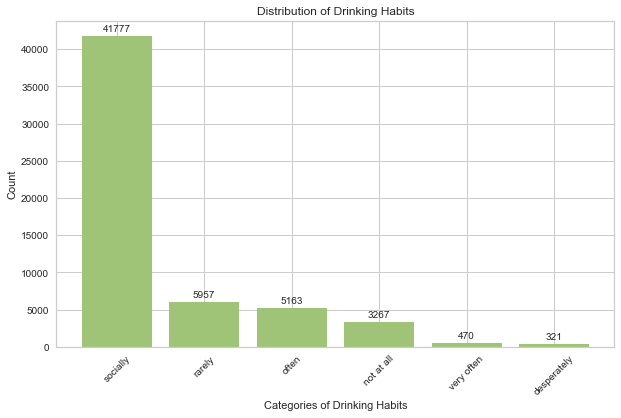

In [23]:
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plt.bar(drinks_counts.index, drinks_counts)

# Add labels and title
plt.xlabel('Categories of Drinking Habits')
plt.ylabel('Count')
plt.title('Distribution of Drinking Habits')
bars = plt.bar(drinks_counts.index, drinks_counts)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords='offset points', ha='center', va='bottom')


# Show the plot
plt.show()

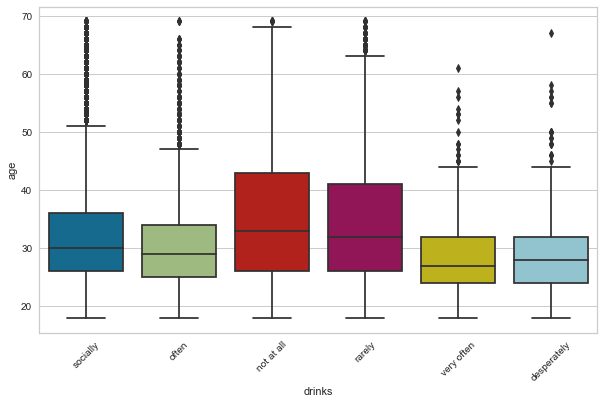

In [24]:
# Create a larger figure
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed
plt.xticks(rotation=45)
# Create the boxplot
sns.boxplot(x='drinks', y='age', data=statd)

# Show the plot
plt.show()

In [25]:
statd['height'].groupby(statd['drinks']).describe()

,count,mean,std,min,25%,50%,75%,max
drinks,,,,,,,,
desperately,321.0,175.214953,13.414098,119.0,168.0,175.0,183.0,241.0
not at all,3267.0,173.382614,10.212736,109.0,168.0,173.0,180.0,239.0
often,5163.0,174.866938,9.858055,94.0,168.0,175.0,183.0,241.0
rarely,5957.0,172.686587,10.104806,91.0,165.0,173.0,180.0,229.0
socially,41777.0,173.363573,9.825065,66.0,165.0,173.0,180.0,241.0
very often,470.0,174.706383,11.216372,124.0,168.0,175.0,183.0,241.0


In [26]:
ds_contingency_table = pd.crosstab(label, statd2.smokes)

# Perform chi-squared test
ds_chi2, ds_p, ds_dof, ds_expected = chi2_contingency(ds_contingency_table)

ds_n = ds_contingency_table.sum().sum()
ds_cramer_v = np.sqrt(ds_chi2 / (ds_n * min(ds_contingency_table.shape) - 1))

# Print results
print("Chi-squared:", ds_chi2)
print("P-value:", ds_p)
print("Degrees of freedom:", ds_dof)
print("\nContingency Table:")
print(ds_contingency_table)
print("\nExpected Frequencies:")
print(pd.DataFrame(ds_expected, index=ds_contingency_table.index, columns=ds_contingency_table.columns))
print("\nCramer's V:", ds_cramer_v)

Chi-squared: 3227.6719886137794
P-value: 0.0
Degrees of freedom: 25

Contingency Table:
smokes        N/A     no  sometimes  trying to quit  when drinking   yes
drinks                                                                  
desperately    33    163         35              21             33    36
not at all     61   2771        159             114             13   149
often         371   2921        603             217            482   569
rarely        131   5080        311             151            119   165
socially     2935  31898       2563             928           2313  1140
very often     28    178         61              20             56   127

Expected Frequencies:
smokes               N/A            no    sometimes  trying to quit  \
drinks                                                                
desperately    20.058625    242.411219    21.033658        8.177877   
not at all    204.148064   2467.157177   214.071530       83.230919   
often         322.625

In [27]:
dr_contingency_table = pd.crosstab(label, statd2.drugs)

# Perform chi-squared test
dr_chi2, dr_p, dr_dof, dr_expected = chi2_contingency(dr_contingency_table)

dr_n = dr_contingency_table.sum().sum()
dr_cramer_v = np.sqrt(dr_chi2 / (dr_n * min(dr_contingency_table.shape) - 1))

# Print results
print("Chi-squared:", dr_chi2)
print("P-value:", dr_p)
print("Degrees of freedom:", dr_dof)
print("\nContingency Table:")
print(dr_contingency_table)
print("\nExpected Frequencies:")
print(pd.DataFrame(dr_expected, index=dr_contingency_table.index, columns=dr_contingency_table.columns))
print("\nCramer's V:", dr_cramer_v)

Chi-squared: 4927.52780745678
P-value: 0.0
Degrees of freedom: 15

Contingency Table:
drugs          N/A  never  often  sometimes
drinks                                     
desperately     89    112     31         89
not at all     200   2920     19        128
often         1335   2149     84       1595
rarely         769   4590     46        552
socially     10248  26255    160       5114
very often      65    172     58        175

Expected Frequencies:
drugs                N/A         never       often    sometimes
drinks                                                         
desperately    71.611377    204.012958    2.243139    43.132526
not at all    728.829813   2076.356176   22.829708   438.984303
often        1151.805425   3281.367290   36.078904   693.748380
rarely       1328.937617   3785.997472   41.627355   800.437556
socially     9319.964217  26551.555544  291.936546  5613.543692
very often    104.851549    298.710561    3.284347    63.153542

Cramer's V: 0.147068468969

In [28]:
ed_contingency_table = pd.crosstab(label, statd2.education)

# Perform chi-squared test
ed_chi2, ed_p, ed_dof, ed_expected = chi2_contingency(ed_contingency_table)

ed_n = ed_contingency_table.sum().sum()
ed_cramer_v = np.sqrt(ed_chi2 / (ed_n * min(ed_contingency_table.shape) - 1))

# Print results
print("Chi-squared:", ed_chi2)
print("P-value:", ed_p)
print("Degrees of freedom:", ed_dof)
print("\nContingency Table:")
print(ed_contingency_table)
print("\nExpected Frequencies:")
print(pd.DataFrame(ed_expected, index=ed_contingency_table.index, columns=ed_contingency_table.columns))
print("\nCramer's V:", ed_cramer_v)

Chi-squared: 668.3222785703781
P-value: 1.0417100013500693e-132
Degrees of freedom: 15

Contingency Table:
education    Graduated   N/A  Not Graduated  Post Graduate
drinks                                                    
desperately        114    33            149             25
not at all        1057   419           1364            427
often             2395   544           1615            609
rarely            2270   583           2204            900
socially         19060  3779          12271           6667
very often         139    75            224             32

Expected Frequencies:
education       Graduated          N/A  Not Graduated  Post Graduate
drinks                                                              
desperately    141.097972    30.620543     100.473479      48.808006
not at all    1436.034501   311.642718    1022.575876     496.746905
often         2269.435607   492.504240    1616.026705     785.033447
rarely        2618.444298   568.244772    1864.549890

In [29]:
# Calculate group means
age_group_means = statd.groupby('drinks')['age'].mean()

# Calculate total mean
age_total_mean = statd['age'].mean()

# Calculate the sum of squares between groups
age_ssb = ((age_group_means - age_total_mean) ** 2).sum()

# Calculate the total sum of squares
age_sst = ((statd['age'] - age_total_mean) ** 2).sum()

# Calculate the sum of squares within (SSW)
age_ssw = age_sst - age_ssb

# Calculate the standard deviation within categories
age_std_within = (age_ssw / (len(statd['age']) - len(age_group_means))) ** 0.5

print(f'Sum of Squares Between (SSB): {age_ssb}')
print(f'Sum of Squares Within (SSW): {age_ssw}')
print(f'Standard Deviation Within Categories: {age_std_within}')

# Calculate H^2
age_h_squared = age_ssb / age_sst

print(f'H^2 (Eta-squared): {age_h_squared}')

Sum of Squares Between (SSB): 38.0717634377286
Sum of Squares Within (SSW): 5101557.784368596
Standard Deviation Within Categories: 9.464732713068653
H^2 (Eta-squared): 7.462716473702433e-06


In [36]:
# Calculate group means
height_group_means = statd.groupby('drinks')['height'].mean()

# Calculate total mean
height_total_mean = statd['height'].mean()

# Calculate the sum of squares between groups
height_ssb = ((height_group_means - height_total_mean) ** 2).sum()

# Calculate the total sum of squares
height_sst = ((statd['height'] - height_total_mean) ** 2).sum()

# Calculate the sum of squares within (SSW)
height_ssw = height_sst - height_ssb

# Calculate the standard deviation within categories
height_std_within = (height_ssw / (len(statd['height']) - len(height_group_means))) ** 0.5

print(f'Sum of Squares Between (SSB): {height_ssb}')
print(f'Sum of Squares Within (SSW): {height_ssw}')
print(f'Standard Deviation Within Categories: {height_std_within}')

# Calculate H^2
height_h_squared = height_ssb / height_sst

print(f'H^2 (Eta-squared): {height_h_squared}')

Sum of Squares Between (SSB): 7.284443647026829
Sum of Squares Within (SSW): 5615642.347090021
Standard Deviation Within Categories: 9.930169667673914
H^2 (Eta-squared): 1.2971684711457692e-06


In [30]:
# Calculate group means
income_group_means = statd.groupby('drinks')['income'].mean()

# Calculate total mean
income_total_mean = statd['income'].mean()

# Calculate the sum of squares between groups
income_ssb = ((income_group_means - income_total_mean) ** 2).sum()

# Calculate the total sum of squares
income_sst = ((statd['income'] - income_total_mean) ** 2).sum()

# Calculate the sum of squares within (SSW)
income_ssw = income_sst - income_ssb

# Calculate the standard deviation within categories
income_std_within = (income_ssw / (len(statd['income']) - len(income_group_means))) ** 0.5

print(f'Sum of Squares Between (SSB): {income_ssb}')
print(f'Sum of Squares Within (SSW): {income_ssw}')
print(f'Standard Deviation Within Categories: {income_std_within}')

# Calculate H^2
income_h_squared = income_ssb / income_sst

print(f'H^2 (Eta-squared): {income_h_squared}')

Sum of Squares Between (SSB): 5175221141.143312
Sum of Squares Within (SSW): 446099323242019.9
Standard Deviation Within Categories: 88506.00358149844
H^2 (Eta-squared): 1.1600916733572635e-05


Analysis with Machine Learning

In [38]:
boosted_df = pd.DataFrame()
boosted_df = stat_df[selected_features]
boosted_df

,age,drugs_never,drugs_sometimes,smokes_no,religion_other,smokes_yes,income,height,education_Not Graduated,diet_vegan,...,asian,body_type_athletic,diet_other,body_type_overweight,lang_spoken,religion_buddhism,status_single,education_Graduated,body_type_fit,offspring_Has Kids
0,22,1,0,0,0,0,104319.248826,190.0,1,0,...,1,0,0,0,1,0,1,0,0,0
1,35,0,1,1,0,0,80000.000000,178.0,1,0,...,0,0,1,0,3,0,1,0,0,0
2,38,0,0,1,0,0,104319.248826,173.0,0,0,...,0,0,0,0,3,0,0,0,0,0
3,23,0,0,1,0,0,20000.000000,180.0,1,0,...,0,0,0,0,2,0,1,0,0,0
4,29,1,0,1,0,0,104319.248826,168.0,0,0,...,1,1,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59932,59,1,0,1,0,0,104319.248826,157.0,0,0,...,0,0,0,0,1,0,1,1,0,1
59933,24,0,1,1,0,0,104319.248826,183.0,1,0,...,0,0,0,0,1,0,1,0,1,0
59934,42,1,0,1,0,0,100000.000000,180.0,0,0,...,1,0,0,0,1,0,1,0,0,0
59935,27,0,0,0,0,0,104319.248826,185.0,1,0,...,1,1,0,0,5,0,1,0,0,0


In [39]:
X_train_fit, X_test_fit, y_train_fit, y_test_fit = train_test_split(boosted_df, label, test_size=0.3, random_state = 1312)

In [40]:
best_train_f1_fit = 0
best_train_auc_fit = 0
best_n_estimators_fit = 0
best_max_features_fit = 0
best_max_depth_fit = 0

for n in range(1,10):
    for m in range(2,5):
        model_fit = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_features=n, max_depth=m)
        model_fit.fit(X_train_fit, y_train_fit)

        # Calculate F1 score for training set
        f1_train_fit = f1_score(y_train_fit, model_fit.predict(X_train_fit), average='weighted')

        # Calculate ROC-AUC score for training set
        roc_auc_train_fit = roc_auc_score(y_train_fit, model_fit.predict_proba(X_train_fit), multi_class='ovr')

        if f1_train_fit > best_train_f1_fit:
            best_train_f1_fit = f1_train_fit
            best_train_auc_fit = roc_auc_train_fit
            best_n_estimators_fit = 100
            best_max_features_fit = n
            best_max_depth_fit = m

# Create and train the best model using the optimal hyperparameters
best_model_fit = GradientBoostingClassifier(n_estimators=best_n_estimators_fit, learning_rate=0.1, max_features=best_max_features_fit, max_depth=best_max_depth_fit)
best_model_fit.fit(X_train_fit, y_train_fit)

# Evaluate the best model on the test set
y_pred_fit = best_model_fit.predict(X_test_fit)

print("Best Hyperparameters:")
print(f"n_estimators: {best_n_estimators_fit}")
print(f"max_features: {best_max_features_fit}")
print(f"max_depth: {best_max_depth_fit}")
print("Best Train F1 Score:", best_train_f1_fit)
print("Best Train AUC-ROC:", best_train_auc_fit)

print("Confusion Matrix:")
print(confusion_matrix(y_test_fit, y_pred_fit))

print("Classification Report")
print(classification_report(y_test_fit, y_pred_fit))

Best Hyperparameters:
n_estimators: 100
max_features: 9
max_depth: 4
Best Train F1 Score: 0.642195331548472
Best Train AUC-ROC: 0.7744249178342866
Confusion Matrix:
[[    0     0     3     2    97     1]
 [    1    19     4     4   939     1]
 [    0     5    24     1  1535     2]
 [    1    17     3     7  1745     0]
 [    3    28    30     9 12458     3]
 [    0     0     7     1   134     3]]
Classification Report
              precision    recall  f1-score   support

 desperately       0.00      0.00      0.00       103
  not at all       0.28      0.02      0.04       968
       often       0.34      0.02      0.03      1567
      rarely       0.29      0.00      0.01      1773
    socially       0.74      0.99      0.85     12531
  very often       0.30      0.02      0.04       145

    accuracy                           0.73     17087
   macro avg       0.32      0.18      0.16     17087
weighted avg       0.62      0.73      0.63     17087



In [41]:
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=1312)
random_forest_classifier.fit(X_train_fit, y_train_fit)


# Make predictions
rf_predictions = random_forest_classifier.predict(X_test_fit)
rf_f1 = f1_score(y_test_fit, rf_predictions, average='weighted')
print(f'Random Forest Classifier F1 Score: {rf_f1:.2f}')

# Calculate ROC-AUC score for Random Forest Classifier
rf_roc_auc = roc_auc_score(y_test_fit, random_forest_classifier.predict_proba(X_test_fit), multi_class='ovr')
print(f'Random Forest Classifier ROC-AUC Score: {rf_roc_auc:.2f}')

Random Forest Classifier F1 Score: 0.62
Random Forest Classifier ROC-AUC Score: 0.62


In [42]:
contingency_table2 = pd.crosstab(y_test_fit, rf_predictions)
print("\nContingency Table:")
print(contingency_table2)

# Chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table2)
print(f"\nChi-squared value: {chi2:.2f}")
print(f"P-value: {p:.4f}")

# Check the significance level (e.g., 0.05)
alpha = 0.05
print("\nSignificance level:", alpha)

# Check the p-value against the significance level
if p <= alpha:
    print("Reject the null hypothesis. There is a significant relationship between the variables.")
else:
    print("Fail to reject the null hypothesis. There is no significant relationship between the variables.")


Contingency Table:
col_0        desperately  not at all  often  rarely  socially  very often
drinks                                                                   
desperately            0           1      3       2        97           0
not at all             0          53     15      51       849           0
often                  1          18     75      33      1436           4
rarely                 0          44     22      79      1626           2
socially               4         171    279     370     11698           9
very often             0           3      6       3       131           2

Chi-squared value: 220.20
P-value: 0.0000

Significance level: 0.05
Reject the null hypothesis. There is a significant relationship between the variables.


In [43]:
max_iter = 10
neighbors  = np.arange(1, max_iter)
test_f1 = np.empty(len(neighbors))
train_f1 = np.empty(len(neighbors))
test_roc_auc = np.empty(len(neighbors))
train_roc_auc = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    #Create KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=i+1)
    #Train the model using the training sets
    knn.fit(X_train_fit, y_train_fit)
    #Predict the response for test dataset
    test_pred_fit = knn.predict(X_test_fit)
    train_pred_fit = knn.predict(X_train_fit)
    train_f1[i] = f1_score(y_train_fit, train_pred_fit, average='weighted')
    test_f1[i] = f1_score(y_test_fit, test_pred_fit, average='weighted')
    train_roc_auc[i] = roc_auc_score(y_train_fit, knn.predict_proba(X_train_fit), multi_class='ovr')
    test_roc_auc[i] = roc_auc_score(y_test_fit, knn.predict_proba(X_test_fit), multi_class='ovr')

In [44]:
print(confusion_matrix(y_test_fit, test_pred_fit))
print(classification_report(y_test_fit, test_pred_fit, zero_division=0))

[[    0     0     1     2   100     0]
 [    0    24     2    22   920     0]
 [    0     5    31    11  1520     0]
 [    0    25     7    37  1704     0]
 [    0    76    82   133 12240     0]
 [    0     1     3     0   141     0]]
              precision    recall  f1-score   support

 desperately       0.00      0.00      0.00       103
  not at all       0.18      0.02      0.04       968
       often       0.25      0.02      0.04      1567
      rarely       0.18      0.02      0.04      1773
    socially       0.74      0.98      0.84     12531
  very often       0.00      0.00      0.00       145

    accuracy                           0.72     17087
   macro avg       0.22      0.17      0.16     17087
weighted avg       0.59      0.72      0.63     17087



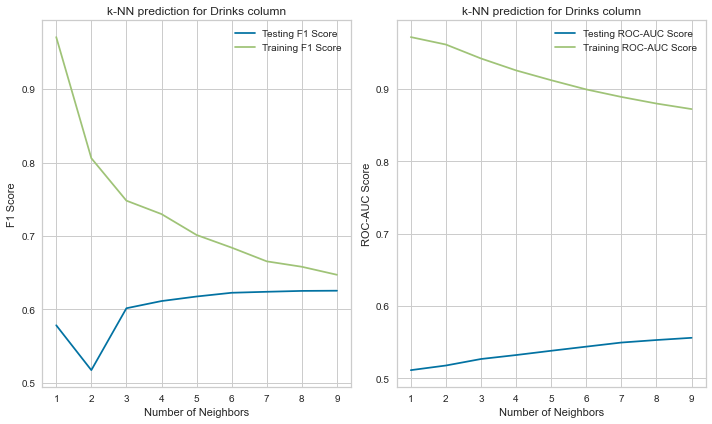

In [46]:
plt.figure(figsize=(10, 6))

# Plotting F1 Scores
plt.subplot(1, 2, 1)
plt.title('k-NN prediction for Drinks column')
plt.plot(neighbors, test_f1, label='Testing F1 Score')
plt.plot(neighbors, train_f1, label='Training F1 Score')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('F1 Score')
plt.savefig('drinks_knn.png', bbox_inches='tight')

# Plotting ROC-AUC Scores
plt.subplot(1, 2, 2)
plt.title('k-NN prediction for Drinks column')
plt.plot(neighbors, test_roc_auc, label='Testing ROC-AUC Score')
plt.plot(neighbors, train_roc_auc, label='Training ROC-AUC Score')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('ROC-AUC Score')

plt.tight_layout()
plt.show()

Natural Language Processing